# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
import os
from pathlib import Path

base = Path.cwd() / "datasets" / "human+activity+recognition+using+smartphones" \
       / "UCI HAR Dataset" / "UCI HAR Dataset"

train_dir = base / "train"
test_dir = base / "test"

X_train = np.loadtxt(train_dir / "X_train.txt")
y_train = np.loadtxt(train_dir / "y_train.txt", dtype=int)
subject_train = np.loadtxt(train_dir / "subject_train.txt", dtype=int)

X_test = np.loadtxt(test_dir / "X_test.txt")
y_test = np.loadtxt(test_dir / "y_test.txt", dtype=int)
subject_test = np.loadtxt(test_dir / "subject_test.txt", dtype=int)

print("Loaded:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Loaded: (7352, 561) (7352,) (2947, 561) (2947,)


In [4]:
# Проверим размерности
assert (X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert (X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate([y_train, y_test], axis=0)

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Mean:", np.round(X_scaled.mean(axis=0)[:5], 3), "…")
print("Std:", np.round(X_scaled.std(axis=0)[:5], 3), "…")

Mean: [ 0. -0. -0. -0.  0.] …
Std: [1. 1. 1. 1. 1.] …


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print("Variance:", pca.explained_variance_ratio_.sum())

Variance: 0.9004833346822929


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- Ok 65
- 66
- 193

In [10]:
print("Component count:", pca.n_components_)

Component count: 65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- Ok 51
- 56
- 61

In [11]:
variance_ratio = pca.explained_variance_ratio_[0]

print(round(variance_ratio * 100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

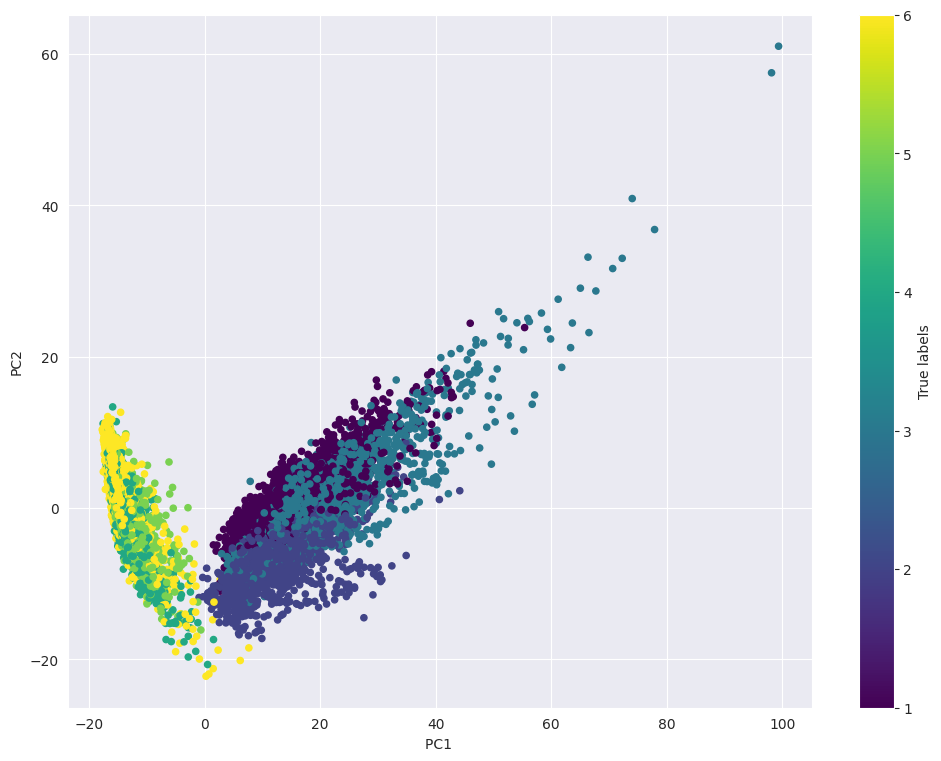

In [12]:
plt.figure(figsize=(12, 9))
plt.scatter(X_pca[:, 0],
            X_pca[:, 1],
            c=y,
            s=20,
            cmap='viridis')
plt.colorbar(label='True labels')
plt.xlabel('PC1 ')
plt.ylabel('PC2')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- Ok 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [13]:
from sklearn.cluster import KMeans

num_clusters = n_classes
initialization_attempts = 100
fixed_random_state = RANDOM_STATE

clustering_model = KMeans(
    n_clusters=num_clusters,
    random_state=fixed_random_state,
    n_init=initialization_attempts
)

predicted_labels = clustering_model.fit_predict(X_pca)

cluster_centers_coordinates = clustering_model.cluster_centers_

print("Инерция модели:", clustering_model.inertia_)

Инерция модели: 2003454.8999158177


In [14]:
import numpy as np

def kmeans_algorithm(data_matrix, num_clusters_val, num_initializations=10, max_iterations=300, convergence_tolerance=1e-4):
    min_overall_inertia = np.inf
    final_labels = None
    final_centroids = None

    for init_run_idx in range(num_initializations):
        initial_centroid_indices = np.random.choice(data_matrix.shape[0], num_clusters_val, replace=False)
        current_centroids = data_matrix[initial_centroid_indices].copy()

        for iter_count in range(max_iterations):
            distances_to_centroids = np.linalg.norm(data_matrix[:, np.newaxis] - current_centroids[np.newaxis, :], axis=2)
            assigned_labels = np.argmin(distances_to_centroids, axis=1)

            new_centroid_positions = np.array([
                data_matrix[assigned_labels == k_idx].mean(axis=0) if np.any(assigned_labels == k_idx) else current_centroids[k_idx]
                for k_idx in range(num_clusters_val)
            ])

            centroid_shift = np.linalg.norm(new_centroid_positions - current_centroids, axis=1).max()
            current_centroids = new_centroid_positions
            if centroid_shift < convergence_tolerance:
                break

        current_inertia = sum(((data_matrix[assigned_labels == k_idx] - current_centroids[k_idx]) ** 2).sum() for k_idx in range(num_clusters_val))

        if current_inertia < min_overall_inertia:
            min_overall_inertia = current_inertia
            final_labels = assigned_labels.copy()
            final_centroids = current_centroids.copy()

    return final_labels, final_centroids, min_overall_inertia

cluster_labels, cluster_centers, model_inertia = kmeans_algorithm(
    X_pca,
    num_clusters_val=n_classes,
    num_initializations=100,
    max_iterations=300,
    convergence_tolerance=1e-4
)

print("KMeans v3:", model_inertia)

KMeans v3: 2003454.7982992884


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

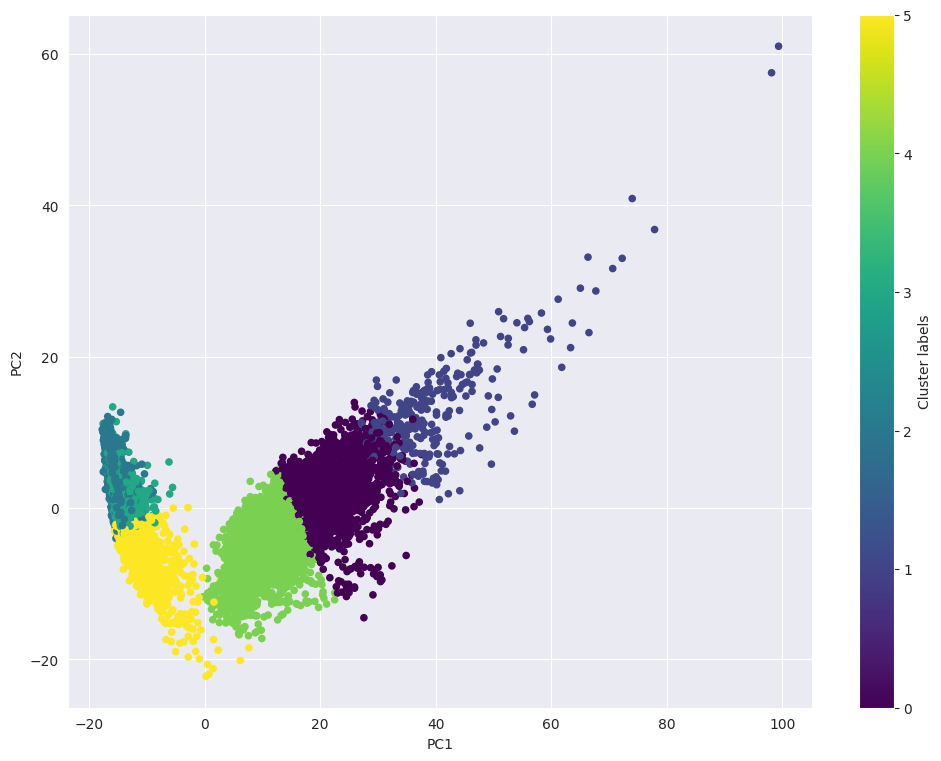

In [15]:
plt.figure(figsize=(12, 9))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    s=20,
    cmap='viridis')
plt.colorbar(label='Cluster labels')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [16]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,741,78,0,0,903,0,1722
подъем вверх по лестнице,296,5,0,0,1241,2,1544
спуск по лестнице,890,196,0,0,320,0,1406
сидение,0,0,91,1235,1,450,1777
стояние,0,0,0,1344,0,562,1906
лежание,0,0,1558,52,5,329,1944
все,1927,279,1649,2631,2470,1343,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- Ok перечисленные варианты не подходят

In [17]:
cluster_population_data = tab.iloc[:-1, :-1]

total_category_counts = tab['все'].iloc[:-1]

relative_proportions = cluster_population_data.divide(total_category_counts, axis='index')

max_proportion_each_category = relative_proportions.max(axis='columns')

top_separated_activity = max_proportion_each_category.idxmax()
top_separation_value = max_proportion_each_category.max()

print(f"Активность с наилучшей отделимостью: «{top_separated_activity}» с максимальной долей {top_separation_value:.2%}")

Активность с наилучшей отделимостью: «подъем вверх по лестнице» с максимальной долей 80.38%


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

Вычисление инерции: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


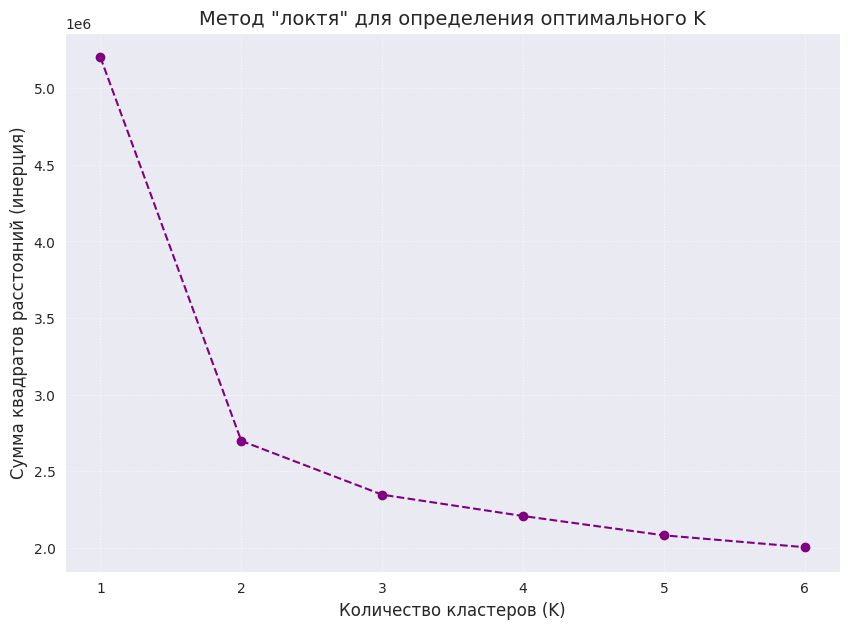

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

inertia = []

possible_k_values = range(1, n_classes + 1)

for k in tqdm(possible_k_values, desc="Вычисление инерции"):
    current_kmeans_model = KMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        n_init=100
    )
    current_kmeans_model.fit(X_pca)
    inertia.append(current_kmeans_model.inertia_)


plt.figure(figsize=(10, 7))

plt.plot(possible_k_values, inertia, marker='o', linestyle='--', color='purple')

plt.xticks(possible_k_values)

plt.xlabel('Количество кластеров (K)', fontsize=12)
plt.ylabel('Сумма квадратов расстояний (инерция)', fontsize=12)
plt.title('Метод "локтя" для определения оптимального K', fontsize=14)

plt.grid(True, linestyle=':', alpha=0.7)

plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- Ok 2
- 3
- 4

In [19]:
cluster_counts_arr = np.array(possible_k_values)
inertia_values_arr = np.array(inertia)

start_point_coords = np.array([cluster_counts_arr[0], inertia_values_arr[0]])
end_point_coords = np.array([cluster_counts_arr[-1], inertia_values_arr[-1]])

connecting_vector = end_point_coords - start_point_coords

numerator_expression = np.abs(
    connecting_vector[1] * (cluster_counts_arr - start_point_coords[0]) -
    connecting_vector[0] * (inertia_values_arr - start_point_coords[1])
)

denominator_norm = np.linalg.norm(connecting_vector)

perpendicular_distances = numerator_expression / denominator_norm

optimal_k_candidate = cluster_counts_arr[np.argmax(perpendicular_distances)]

print(f"Предполагаемое оптимальное количество кластеров: {optimal_k_candidate}")

Предполагаемое оптимальное количество кластеров: 2


------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [21]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)
labels_ag = ag.labels_

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

optimal_kmeans_model = KMeans(
    n_clusters=n_classes,
    random_state=RANDOM_STATE,
    n_init=100
).fit(X_pca)

predicted_labels_kmeans = optimal_kmeans_model.labels_

ari_for_agglomerative = adjusted_rand_score(y, labels_ag)
ari_for_kmeans = adjusted_rand_score(y, predicted_labels_kmeans)

print(f"ARI для Агломеративной: {ari_for_agglomerative:.4f}")
print(f"ARI для K-Means:       {ari_for_kmeans:.4f}")

ARI для Агломеративной: 0.4936
ARI для K-Means:       0.4198


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Ok Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Ok Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- Ok В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [25]:
grid_search_optimizer = GridSearchCV(
    estimator=svc,
    cv=3,
    param_grid=svc_params,
    n_jobs=-1
)

grid_search_optimizer.fit(X_train_scaled, y_train)

best_svc = grid_search_optimizer.best_estimator_

highest_validation_score = grid_search_optimizer.best_score_

In [27]:
print(f"Оптимальные параметры модели: {grid_search_optimizer.best_params_}")

print(f"Точность на тренировочном наборе: {grid_search_optimizer.best_score_:.4f}")

test_set_accuracy = best_svc.score(X_test_scaled, y_test)
print(f"Точность на тестовом наборе:        {test_set_accuracy:.4f}")

Оптимальные параметры модели: {'C': 0.1}
Точность на тренировочном наборе: 0.9380
Точность на тестовом наборе:        0.9620


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- Ok 0.1
- 1
- 10

In [28]:
y_predicted = best_svc.predict(X_test_scaled)

In [29]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние

- Ok Ни один

In [31]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

activity_labels_map = [
    'ходьба',
    'подъем вверх по лестнице',
    'спуск по лестнице',
    'сидение',
    'стояние',
    'лежание'
]

per_class_precision = precision_score(
    y_true=y_test,
    y_pred=y_predicted,
    labels=np.arange(1, 7),
    average=None
)

per_class_recall = recall_score(
    y_true=y_test,
    y_pred=y_predicted,
    labels=np.arange(1, 7),
    average=None
)

lowest_precision_index = np.argmin(per_class_precision)

lowest_recall_index = np.argmin(per_class_recall)

print(f"Активность с наименьшей точностью: {activity_labels_map[lowest_precision_index]}")
print(f"Активность с наименьшей полнотой:  {activity_labels_map[lowest_recall_index]}")

Активность с наименьшей точностью: стояние
Активность с наименьшей полнотой:  сидение


Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- Ok 4%
- 10%
- 20%


In [32]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
dimensionality_reducer = PCA(n_components=0.9, random_state=RANDOM_STATE)

features_train_pca = dimensionality_reducer.fit_transform(X_train_scaled)

features_test_pca = dimensionality_reducer.transform(X_test_scaled)

linear_svc_model = LinearSVC(random_state=RANDOM_STATE, max_iter=1000)

hyperparameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

grid_search_processor = GridSearchCV(
    estimator=linear_svc_model,
    cv=3,
    param_grid=hyperparameter_grid,
    n_jobs=-1
)

grid_search_processor.fit(features_train_pca, y_train)

best_cv_score_after_pca = grid_search_processor.best_score_

optimal_svc_pca_model = grid_search_processor.best_estimator_

performance_difference_percent = round((highest_validation_score - best_cv_score_after_pca) * 100)

print(f"  Оптимальное значение C:    {grid_search_processor.best_params_['C']}")
print(f"  Точность CV (с PCA):       {grid_search_processor.best_score_:.4f}")
print(f"  Точность на тесте (с PCA): {optimal_svc_pca_model.score(features_test_pca, y_test):.4f}")
print(f"Разница в качестве CV:      {performance_difference_percent}%")

  Оптимальное значение C:    0.1
  Точность CV (с PCA):       0.8984
  Точность на тесте (с PCA): 0.9192
Разница в качестве CV:      4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- Ok PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- Ok PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

Выбранное значение epsilon (из графика k-расстояний): 43.23


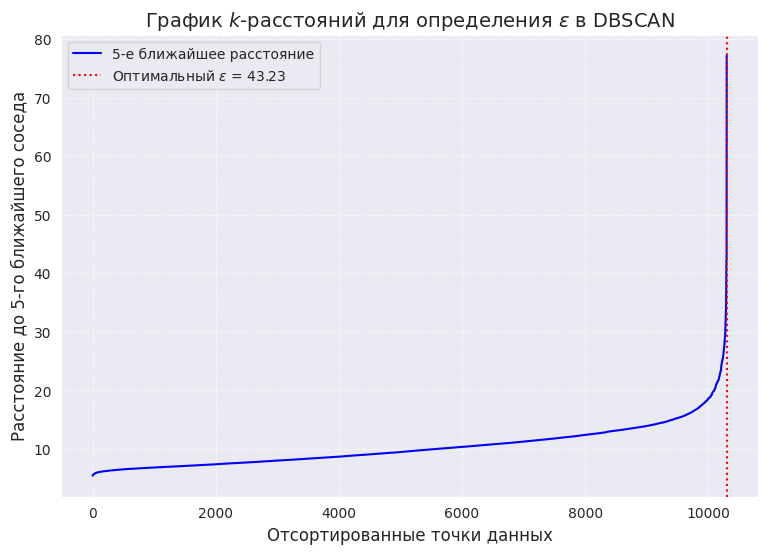

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

neighbor_finder = NearestNeighbors(n_neighbors=5)
neighbor_finder.fit(X_pca)

distances_to_neighbors, _ = neighbor_finder.kneighbors(X_pca)

sorted_k_distances = np.sort(distances_to_neighbors[:, 4])

first_derivative = np.gradient(sorted_k_distances)
second_derivative = np.gradient(first_derivative)
elbow_index = np.argmax(second_derivative)

chosen_epsilon_value = sorted_k_distances[elbow_index]

print(f"Выбранное значение epsilon (из графика k-расстояний): {chosen_epsilon_value:.2f}")

plt.figure(figsize=(9, 6))

plt.plot(sorted_k_distances, label='5-е ближайшее расстояние', color='blue')

plt.axvline(
    x=elbow_index,
    color='red',
    linestyle=':', # Изменен стиль линии
    label=f'Оптимальный $\\epsilon$ = {chosen_epsilon_value:.2f}'
)

plt.legend(fontsize=10)
plt.title('График $k$-расстояний для определения $\\epsilon$ в DBSCAN', fontsize=14)
plt.ylabel('Расстояние до 5-го ближайшего соседа', fontsize=12)
plt.xlabel('Отсортированные точки данных', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Распределение кластеров DBSCAN: Counter({np.int64(0): 9661, np.int64(-1): 573, np.int64(1): 45, np.int64(5): 11, np.int64(4): 4, np.int64(3): 3, np.int64(2): 2})


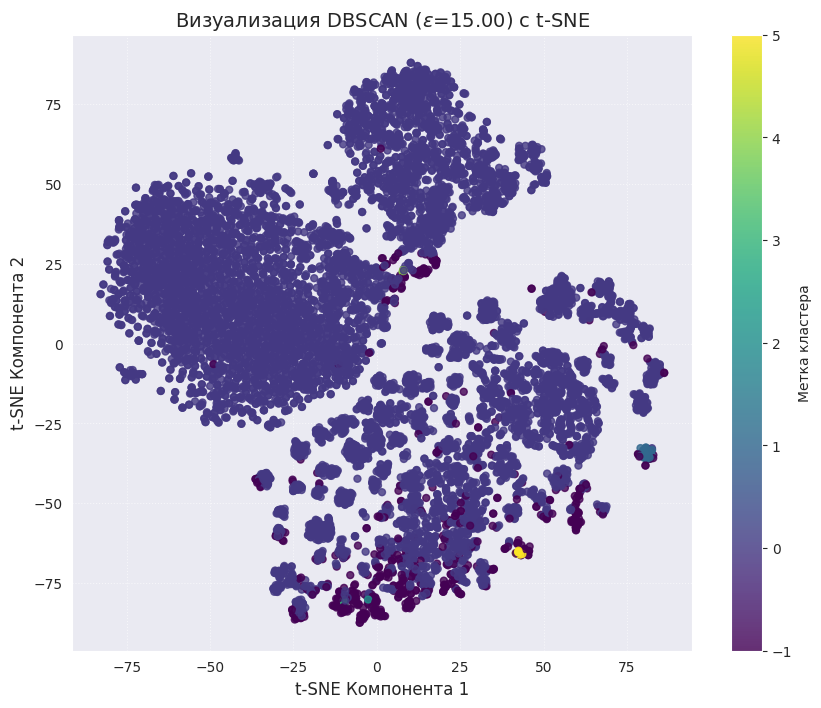

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from collections import Counter

epsilon_radius = 15
min_points_in_cluster = 5
density_based_clusterer = DBSCAN(eps=epsilon_radius, min_samples=min_points_in_cluster)
density_based_clusterer.fit(X_pca)

cluster_assignment_counts = Counter(density_based_clusterer.labels_)
print("Распределение кластеров DBSCAN:", cluster_assignment_counts)

tsne_transformer = TSNE(n_components=2, random_state=RANDOM_STATE, init='random')
transformed_data_2d = tsne_transformer.fit_transform(X_pca)

plt.figure(figsize=(10, 8))

plt.scatter(
    transformed_data_2d[:, 0],
    transformed_data_2d[:, 1],
    c=density_based_clusterer.labels_,
    cmap='viridis',
    s=25,
    alpha=0.8
)

plt.colorbar(label='Метка кластера')
plt.title(f'Визуализация DBSCAN ($\\epsilon$={epsilon_radius:.2f}) с t-SNE', fontsize=14)
plt.xlabel('t-SNE Компонента 1', fontsize=12)
plt.ylabel('t-SNE Компонента 2', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()